In [40]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("bbc_data.csv")
df_fox = pd.read_csv("fox_news_data.csv")
df_fox = df_fox.dropna(how="any",axis=0)
df['category_id'] = df.category.factorize()[0]
df_fox['category_id'] = df_fox.category.factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df_fox = df_fox[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
category_to_id_fox = dict(category_id_df_fox.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
id_to_category_fox = dict(category_id_df_fox[['category_id', 'category']].values)
print(df.head(-10))
print(df_fox.head(-10))

      category filename                                   title  \
0     business  001.txt   Ad sales boost Time Warner profit\r\n   
1     business  002.txt    Dollar gains on Greenspan speech\r\n   
2     business  003.txt   Yukos unit buyer faces loan claim\r\n   
3     business  004.txt   High fuel prices hit BA's profits\r\n   
4     business  005.txt   Pernod takeover talk lifts Domecq\r\n   
5     business  006.txt    Japan narrowly escapes recession\r\n   
6     business  007.txt    Jobs growth still slow in the US\r\n   
7     business  008.txt    India calls for fair trade rules\r\n   
8     business  009.txt   Ethiopia's crop production up 24%\r\n   
9     business  010.txt   Court rejects $280bn tobacco case\r\n   
10    business  011.txt   Ask Jeeves tips online ad revival\r\n   
11    business  012.txt    Indonesians face fuel price rise\r\n   
12    business  013.txt      Peugeot deal boosts Mitsubishi\r\n   
13    business  014.txt    Telegraph newspapers axe 90 jobs\r\

In [54]:
# df.groupby('category').filename.count().plot.bar(ylim=0)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.content).toarray()
labels = df.category_id
features.shape


(2225, 14316)

In [3]:
# from sklearn.feature_selection import chi2

# N = 3
# for category, category_id in sorted(category_to_id.items()):
#     features_chi2 = chi2(features, labels == category_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(category))
#     print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

Text(0.5,1,'tf-idf feature vector for each article, projected on 2 dimensions.')

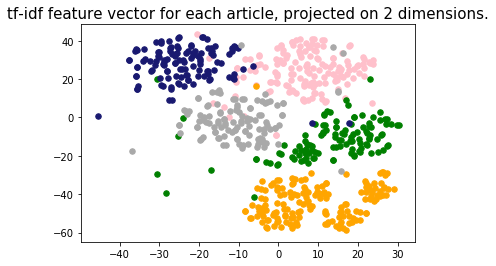

In [4]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import LinearSVC  

from sklearn.model_selection import cross_val_score


models = [
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=5),
    LinearSVC(multi_class='ovr')     
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier    0.955052
LinearSVC               0.973490
LogisticRegression      0.966765
MultinomialNB           0.960461
Name: accuracy, dtype: float64

In [34]:
# print(df.head())
print(df_fox.content)

0       Ad sales boost Time Warner profitQuarterly pro...
1       Dollar gains on Greenspan speechThe dollar has...
2       Yukos unit buyer faces loan claimThe owners of...
3       High fuel prices hit BA's profitsBritish Airwa...
4       Pernod takeover talk lifts DomecqShares in UK ...
5       Japan narrowly escapes recessionJapan's econom...
6       Jobs growth still slow in the USThe US created...
7       India calls for fair trade rulesIndia, which a...
8       Ethiopia's crop production up 24%Ethiopia prod...
9       Court rejects $280bn tobacco caseA US governme...
10      Ask Jeeves tips online ad revivalAsk Jeeves ha...
11      Indonesians face fuel price riseIndonesia's go...
12      Peugeot deal boosts MitsubishiStruggling Japan...
13      Telegraph newspapers axe 90 jobsThe Daily and ...
14      Air passengers win new EU rightsAir passengers...
15      China keeps tight rein on creditChina's effort...
16      Parmalat boasts doubled profitsParmalat, the I...
17      India'

Without K-fold Accuracy for Logistic Regression
0.43177570093457945


Text(0.5,15,'Predicted')

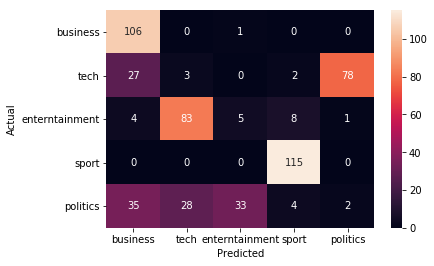

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

model = LogisticRegression(random_state=0)

# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0, random_state=0)
X_train = features
y_train = labels
model.fit(X_train, y_train)
count = CountVectorizer()
X_test = tfidf.transform(df_fox.content).toarray()

y_test = df_fox.category_id
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_fox.index, test_size=1.00, random_state=0)
# y_pred_proba = model.predict_proba(X_test)

y_pred = model.predict(X_test)

from sklearn import metrics
acc =metrics.accuracy_score(y_test, y_pred)
print("Without K-fold Accuracy for Logistic Regression")
print(acc)

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_fox.category.values, yticklabels=category_id_df_fox.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Accuracy for Logistic REgression
0.9768707482993197


Without K-fold Accuracy for Multinomial NB
0.9714285714285714


Text(0.5,15,'Predicted')

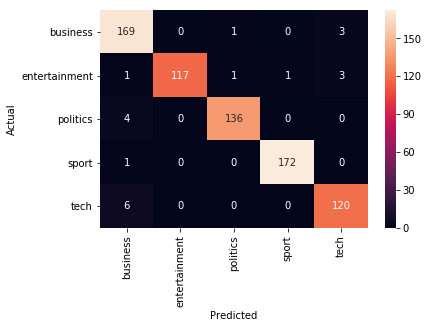

In [56]:
from sklearn.model_selection import train_test_split

model = MultinomialNB()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)


from sklearn import metrics
acc =metrics.accuracy_score(y_test, y_pred)
print("Without K-fold Accuracy for Multinomial NB")
print(acc)


from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Without K-fold Accuracy for Multinomial NB
0.44485981308411215


Text(0.5,15,'Predicted')

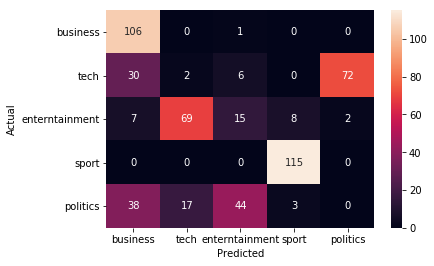

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

model = MultinomialNB()

# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0, random_state=0)
X_train = features
y_train = labels
model.fit(X_train, y_train)
count = CountVectorizer()
X_test = tfidf.transform(df_fox.content).toarray()

y_test = df_fox.category_id
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_fox.index, test_size=1.00, random_state=0)
# y_pred_proba = model.predict_proba(X_test)

y_pred = model.predict(X_test)

from sklearn import metrics
acc =metrics.accuracy_score(y_test, y_pred)
print("Without K-fold Accuracy for Multinomial NB")
print(acc)

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_fox.category.values, yticklabels=category_id_df_fox.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Without K-fold Accuracy for KNeighborsClassifier
0.964625850340136


Text(0.5,15,'Predicted')

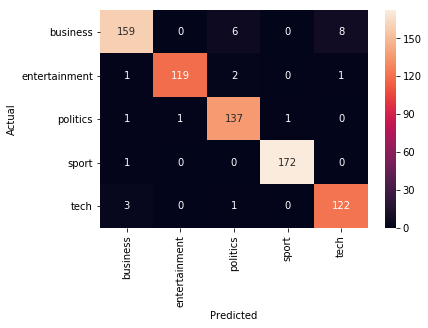

In [61]:
from sklearn.model_selection import train_test_split

model = KNeighborsClassifier(n_neighbors=5)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)


from sklearn import metrics
acc =metrics.accuracy_score(y_test, y_pred)
print("Without K-fold Accuracy for KNeighborsClassifier")
print(acc)


from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Without K-fold Accuracy for KNeighborsClassifier
0.4542056074766355


Text(0.5,15,'Predicted')

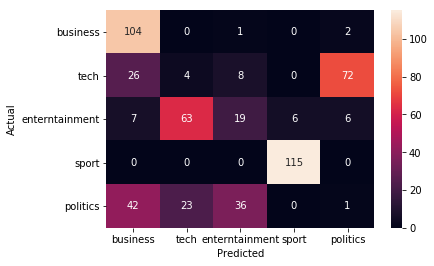

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

model = KNeighborsClassifier(n_neighbors=5)

# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0, random_state=0)
X_train = features
y_train = labels
model.fit(X_train, y_train)
count = CountVectorizer()
X_test = tfidf.transform(df_fox.content).toarray()

y_test = df_fox.category_id
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_fox.index, test_size=1.00, random_state=0)
# y_pred_proba = model.predict_proba(X_test)

y_pred = model.predict(X_test)

from sklearn import metrics
acc =metrics.accuracy_score(y_test, y_pred)
print("Without K-fold Accuracy for KNeighborsClassifier")
print(acc)

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_fox.category.values, yticklabels=category_id_df_fox.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Without K-fold Accuracy for LinearSVC
0.9836734693877551


Text(0.5,15,'Predicted')

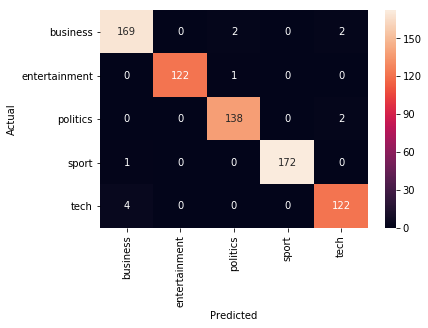

In [59]:
from sklearn.model_selection import train_test_split

model = LinearSVC(multi_class='ovr')

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn import metrics
acc =metrics.accuracy_score(y_test, y_pred)
print("Without K-fold Accuracy for LinearSVC")
print(acc)


from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Without K-fold Accuracy for Linear SVC
0.43177570093457945


Text(0.5,15,'Predicted')

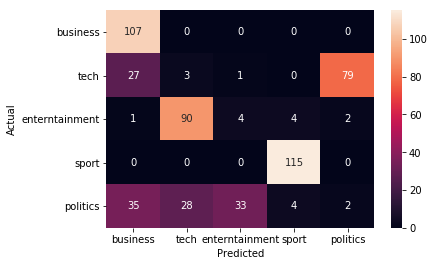

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

model = LinearSVC(multi_class='ovr')

# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0, random_state=0)
X_train = features
y_train = labels
model.fit(X_train, y_train)
count = CountVectorizer()
X_test = tfidf.transform(df_fox.content).toarray()

y_test = df_fox.category_id
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_fox.index, test_size=1.00, random_state=0)
# y_pred_proba = model.predict_proba(X_test)

y_pred = model.predict(X_test)

from sklearn import metrics
acc =metrics.accuracy_score(y_test, y_pred)
print("Without K-fold Accuracy for Linear SVC")
print(acc)

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_fox.category.values, yticklabels=category_id_df_fox.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')